In [1]:
#Mount Google Drive
#Connect Google Drive
from google.colab import drive
force_remount=True
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/Colab Notebooks/TIMESERIES/

/content/drive/My Drive/Colab Notebooks/TIMESERIES


In [3]:
#Import API Account Kaggle
from google.colab import files
!ls -lha kaggle.json

-rw------- 1 root root 70 Nov 27 06:51 kaggle.json


In [4]:
#Need Permission
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd

/content/drive/My Drive/Colab Notebooks/TIMESERIES


In [5]:
#Download Dataset From Kaggle
!kaggle datasets download -d sudalairajkumar/daily-temperature-of-major-cities

 39% 5.00M/12.9M [00:00<00:00, 42.3MB/s]
100% 12.9M/12.9M [00:00<00:00, 77.0MB/s]


In [6]:
#Ekstrak File Dataset
!unzip daily-temperature-of-major-cities.zip

Archive:  daily-temperature-of-major-cities.zip
  inflating: city_temperature.csv    


In [7]:
#Import Library
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
#Load File
df = pd.read_csv("city_temperature.csv")
df.head(10)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9
5,Africa,Algeria,NaN,Algiers,1,6,1995,48.7
6,Africa,Algeria,NaN,Algiers,1,7,1995,48.9
7,Africa,Algeria,NaN,Algiers,1,8,1995,49.1
8,Africa,Algeria,NaN,Algiers,1,9,1995,49.0
9,Africa,Algeria,NaN,Algiers,1,10,1995,51.9


In [9]:
#Drop Collumn
df = pd.read_csv("city_temperature.csv")
df = df[df.Region == 'North America']
df = df[df.Country == 'Canada']
df = df[df.City == 'Vancouver']
df.reset_index(drop=True, inplace=True)
df.drop(columns=['Region','Country','State','City'], inplace=True)
df.head(10)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Month,Day,Year,AvgTemperature
0,1,1,1995,30.3
1,1,2,1995,29.6
2,1,3,1995,29.4
3,1,4,1995,29.2
4,1,5,1995,30.1
5,1,6,1995,30.2
6,1,7,1995,30.3
7,1,8,1995,40.4
8,1,9,1995,43.6
9,1,10,1995,46.0


In [10]:
df['date'] = pd.to_datetime(df.apply(lambda x:'%s-%s-%s' % (int(x['Year']), int(x['Month']), int(x['Day'])), axis=1))
df.drop(columns=['Year','Month','Day'], inplace=True)
df.head(10)

,AvgTemperature,date
0,30.3,1995-01-01
1,29.6,1995-01-02
2,29.4,1995-01-03
3,29.2,1995-01-04
4,30.1,1995-01-05
5,30.2,1995-01-06
6,30.3,1995-01-07
7,40.4,1995-01-08
8,43.6,1995-01-09
9,46.0,1995-01-10


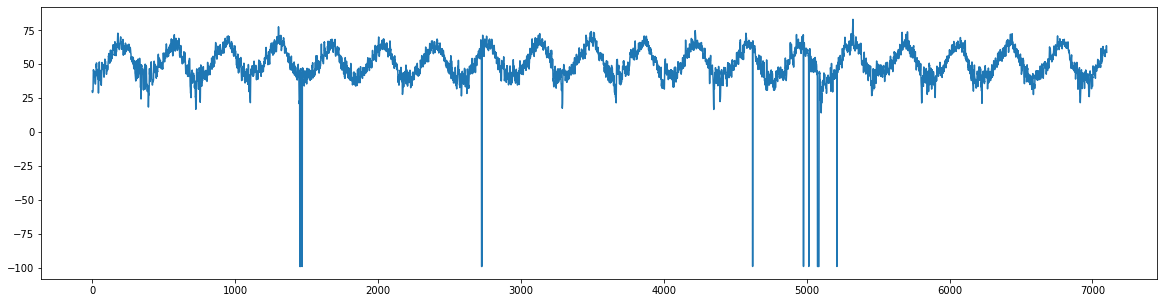

In [11]:
fig = plt.figure(figsize=(20,5))
plt.plot(df['AvgTemperature'])
plt.show()

In [12]:
tf.keras.backend.set_floatx('float64')

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
#Split Data
X = df['date']
y = df['AvgTemperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
#Jumlah Data Train
len(X_train)

5680

In [15]:
#Jumlah Data Val
len(X_test)

1421

In [16]:
train_set = windowed_dataset(y_train, window_size=64, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, window_size=64, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([tf.keras.layers.LSTM(60, return_sequences=True),
                                    tf.keras.layers.LSTM(60),
                                    tf.keras.layers.Dense(30, activation="relu"),
                                    tf.keras.layers.Dense(10, activation="relu"),
                                    tf.keras.layers.Dense(1),])

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [18]:
MAE = (df['AvgTemperature'].max() - df['AvgTemperature'].min()) * 10/100

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<MAE and logs.get('val_mae')<MAE):
      print("\n\nMAE criteria < 10% of the data scale")
      self.model.stop_training = True
callbacks = myCallback()

In [19]:
hist = model.fit(train_set, epochs = 50, validation_data = test_set, verbose = 1, callbacks=[callbacks])

Epoch 1/50
57/57 [==============================] - 37s 479ms/step - loss: 50.0978 - mae: 50.5978 - val_loss: 49.6060 - val_mae: 50.1060
Epoch 2/50
57/57 [==============================] - 23s 407ms/step - loss: 49.4921 - mae: 49.9921 - val_loss: 48.8983 - val_mae: 49.3983
Epoch 3/50
57/57 [==============================] - 23s 400ms/step - loss: 48.5434 - mae: 49.0434 - val_loss: 47.6011 - val_mae: 48.1011
Epoch 4/50
57/57 [==============================] - 25s 429ms/step - loss: 46.6667 - mae: 47.1667 - val_loss: 44.8486 - val_mae: 45.3486
Epoch 5/50
57/57 [==============================] - 23s 406ms/step - loss: 42.0215 - mae: 42.5215 - val_loss: 36.9643 - val_mae: 37.4643
Epoch 6/50
57/57 [==============================] - 23s 406ms/step - loss: 25.4567 - mae: 25.9536 - val_loss: 8.5191 - val_mae: 9.0074
Epoch 7/50
57/57 [==============================] - ETA: 0s - loss: 8.7482 - mae: 9.2381

MAE criteria < 10% of the data scale
57/57 [==============================] - 23s 395ms/st